# ECE 491 — Homework 6 (Convolutions & CNN)

**Student:** Ameen

This notebook meets the assignment requirements:
- **Solutions** with all work shown
- **Code**
- **Output** (printed values, plots, confusion matrix)

## Weekly Learning Objectives
- LO3: Justify transition from FC to conv layers; visualize convolutions
- LO3: Analyze strides & padding
- LO2/LO3: Implement pooling
- LO3: Observe GoogLeNet/AlexNet and compare


## Q1 — 1D Convolution (by hand) & Correlation

Given:
- x = {1, 2, 3, 4}
- h = {1, 2}

**Convolution (with flip)**
\[
(h * x)[n] = \sum_k h[k] \cdot x[n - k]
\]

**Correlation (no flip)**
\[
(h \star x)[n] = \sum_k h[k] \cdot x[n + k]
\]

We compute both and comment on the difference.


In [1]:
import numpy as np

x = np.array([1,2,3,4], dtype=float)
h = np.array([1,2], dtype=float)

def conv1d_full(x, h):
    # Convolution with flip (full)
    h_flip = h[::-1]
    return np.convolve(x, h_flip, mode='full')

def corr1d_full(x, h):
    # Correlation (no flip) equals conv with h (unflipped)
    return np.convolve(x, h, mode='full')

y_conv = conv1d_full(x, h)
y_corr = corr1d_full(x, h)

print("x:", x)
print("h:", h)
print("\n1D convolution (with flip):", y_conv)
print("1D correlation (no flip):", y_corr)

print("\nObservation:")
print("- They differ due to flipping in convolution. For this short example,")
print("  the numbers appear mirrored vs correlation (up to indexing).")


x: [1. 2. 3. 4.]
h: [1. 2.]

1D convolution (with flip): [ 2.  5.  8. 11.  4.]
1D correlation (no flip): [ 1.  4.  7. 10.  8.]

Observation:
- They differ due to flipping in convolution. For this short example,
  the numbers appear mirrored vs correlation (up to indexing).


## Q2 — 2D Convolution (3×3 image, 3×3 filter)

Image:
\[
x = \begin{bmatrix}
-4 & 1 & -3 \\
3 & -2 & -3 \\
-4 & 2 & -3
\end{bmatrix}
\]
Filter:
\[
h = \begin{bmatrix}
1 & 0 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0
\end{bmatrix}
\]

Compute **y = h * x** (2D convolution with flip). We show the "same" output with zero padding and print per-location patch × kernel products.


In [2]:
import numpy as np

x2 = np.array([[-4,  1, -3],
               [ 3, -2, -3],
               [-4,  2, -3]], dtype=float)
h2 = np.array([[1,0,0],
               [0,0,1],
               [0,0,0]], dtype=float)

def conv2d_same(img, ker):
    k = ker[::-1, ::-1]  # flip both axes
    H, W = img.shape
    kH, kW = k.shape
    pad_y, pad_x = kH//2, kW//2
    padded = np.pad(img, ((pad_y,pad_y),(pad_x,pad_x)), mode='constant')
    out = np.zeros_like(img)
    print("Intermediate products (centered patches):")
    for i in range(H):
        for j in range(W):
            patch = padded[i:i+kH, j:j+kW]
            prod = patch * k
            out[i,j] = prod.sum()
            print(f"(i={i}, j={j})\npatch=\n{patch}\nflipped kernel=\n{k}\nprod=\n{prod}\nsum={out[i,j]}\n")
    return out

y2 = conv2d_same(x2, h2)
print("x =\n", x2)
print("h =\n", h2)
print("\n2D convolution y = h * x (same):\n", y2)


Intermediate products (centered patches):
(i=0, j=0)
patch=
[[ 0.  0.  0.]
 [ 0. -4.  1.]
 [ 0.  3. -2.]]
flipped kernel=
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
prod=
[[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -2.]]
sum=-2.0

(i=0, j=1)
patch=
[[ 0.  0.  0.]
 [-4.  1. -3.]
 [ 3. -2. -3.]]
flipped kernel=
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
prod=
[[ 0.  0.  0.]
 [-4.  0. -0.]
 [ 0. -0. -3.]]
sum=-7.0

(i=0, j=2)
patch=
[[ 0.  0.  0.]
 [ 1. -3.  0.]
 [-2. -3.  0.]]
flipped kernel=
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
prod=
[[ 0.  0.  0.]
 [ 1. -0.  0.]
 [-0. -0.  0.]]
sum=1.0

(i=1, j=0)
patch=
[[ 0. -4.  1.]
 [ 0.  3. -2.]
 [ 0. -4.  2.]]
flipped kernel=
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
prod=
[[ 0. -0.  0.]
 [ 0.  0. -0.]
 [ 0. -0.  2.]]
sum=2.0

(i=1, j=1)
patch=
[[-4.  1. -3.]
 [ 3. -2. -3.]
 [-4.  2. -3.]]
flipped kernel=
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
prod=
[[-0.  0. -0.]
 [ 3. -0. -0.]
 [-0.  0. -3.]]
sum=0.0

(i=1, j=2)
patch=
[[ 1. -3.  0.]
 [-2. -3.  0.]
 [ 2. -3.  0.]]
fl

## Q3 — CNN on Fashion-MNIST (≥3 conv layers)
**Architecture**
- Conv(32,3,relu) → Conv(32,3,relu) → MaxPool(2)
- Conv(64,3,relu) → MaxPool(2)
- Flatten → Dense(128,relu) → Dense(10, logits)
- Loss: SparseCategoricalCrossentropy(from_logits=True)
- Optimizer: Adam(lr=1e-3)
- Train: 10 epochs, batch=128

We report train/val loss curves, test accuracy, and a confusion matrix.


### Installation Instructions (if needed)

If you encounter import errors, run these commands in your terminal:

```bash
pip install scikit-learn seaborn
```

Or if using conda:
```bash
conda install scikit-learn seaborn
```

The code below includes fallbacks if these packages are not available.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,890 (1.64 MB)

 Trainable params: 430,890 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
422/422 - 14s - 34ms/step - accuracy: 0.8217 - loss: 0.4981 - val_accuracy: 0.8807 - val_loss: 0.3323
Epoch 2/10
422/422 - 12s - 29ms/step - accuracy: 0.8943 - loss: 0.2975 - val_accuracy: 0.8972 - val_loss: 0.2784
Epoch 3/10
422/422 - 13s - 30ms/step - accuracy: 0.9145 - loss: 0.2391 - val_accuracy: 0.9118 - val_loss: 0.2452
Epoch 4/10
422/422 - 12s - 29ms/step - accuracy: 0.9237 - loss: 0.2085 - val_accuracy: 0.9177 - val_loss: 0.2355
Epoch 5/10
422/422 - 13s - 30ms/step - accuracy: 0.9345 - loss: 0.1813 - val_accuracy: 0.9218 - val_loss: 0.2173
Epoch 6/10
422/422 - 12s - 29ms/step - accuracy: 0.9416 - loss: 0.1609 - val_accuracy: 0.9202 - val_loss: 0.2238
Epoch 7/10
422/422 - 12s - 29ms/step - accuracy: 0.9483 - loss: 0.1403 - val_accuracy: 0.9203 - val_loss: 0.2221
Epoch 8/10
422/422 - 12s - 29ms/step - accuracy: 0.9556 - loss: 0.1218 - val_accuracy: 0.9253 - val_loss: 0.2217
Epoch 9/10
422/422 - 13s - 30ms/step - accuracy: 0.9625 - loss: 0.1041 - val_accuracy: 0.9148 - 

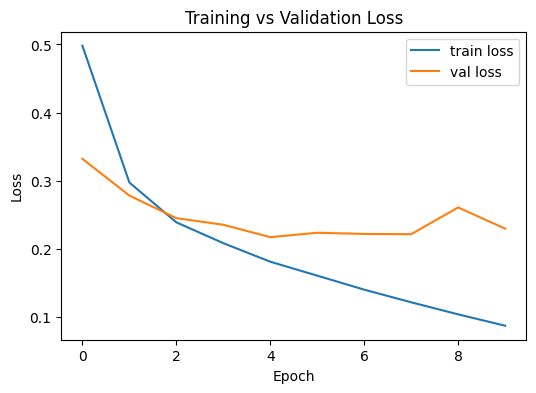

Test accuracy: 0.9189


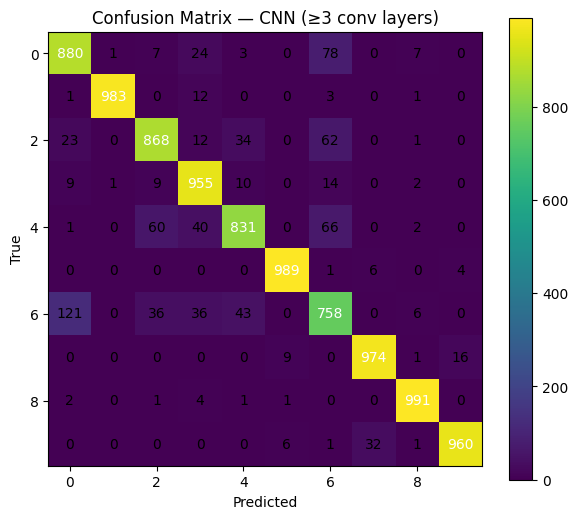

In [5]:
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Try to import sklearn and seaborn, with fallbacks if not available
try:
    from sklearn.metrics import confusion_matrix
    HAS_SKLEARN = True
except ImportError:
    print("Warning: sklearn not available. Will use TensorFlow's confusion matrix.")
    HAS_SKLEARN = False

try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    print("Warning: seaborn not available. Will use matplotlib for plotting.")
    HAS_SEABORN = False

# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype("float32")/255.0)[..., None]  # (N,28,28,1)
x_test  = (x_test.astype("float32")/255.0)[..., None]

def build_cnn():
    inputs = tf.keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    logits = layers.Dense(10)(x)
    model = models.Model(inputs, logits)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    return model

model = build_cnn()
model.summary()

history = model.fit(x_train, y_train, validation_split=0.1,
                    epochs=10, batch_size=128, verbose=2)

# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()

# Evaluate
logits = model.predict(x_test, batch_size=512, verbose=0)
y_pred = np.argmax(logits, axis=1)
test_acc = (y_pred == y_test).mean()
print("Test accuracy:", test_acc)

# Confusion matrix
if HAS_SKLEARN:
    cm = confusion_matrix(y_test, y_pred)
else:
    # Fallback: create confusion matrix manually
    num_classes = 10
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_test, y_pred):
        cm[true_label, pred_label] += 1

plt.figure(figsize=(7,6))
if HAS_SEABORN:
    sns.heatmap(cm, cmap="viridis")
else:
    plt.imshow(cm, cmap="viridis")
    plt.colorbar()
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

plt.title("Confusion Matrix — CNN (≥3 conv layers)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


### Discussion: CNN vs FCN, GoogLeNet, AlexNet
- **CNN vs FCN:** FC layers ignore spatial structure and have many parameters; CNNs share weights and exploit locality → fewer parameters, better inductive bias.
- **vs GoogLeNet:** GoogLeNet uses Inception blocks (parallel convs at multiple scales with 1×1 bottlenecks) for multi-scale features and parameter efficiency. Our CNN is a small sequential stack for 28×28 grayscale images.
- **vs AlexNet:** AlexNet is much larger (ImageNet-scale), early large kernels, ReLU, dropout, local response normalization, and trained on GPUs. Our model is much smaller and tailored to Fashion-MNIST.
- **Strides & Padding:** Strides downsample; padding preserves resolution ("same") or reduces it ("valid").
- **Pooling:** Max/avg pooling reduces tensor size and offers small translation invariance.
